In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, coo_matrix, hstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import nltk
#nltk.download()

train_df = pd.read_csv('train.csv')
#train_df.head()
print(train_df)

            id                        url  \
0            0                    m.kp.md   
1            1                  www.kp.by   
2            2              fanserials.tv   
3            3            colorbox.spb.ru   
4            4              tula-sport.ru   
...        ...                        ...   
135304  135304                    mail.ru   
135305  135305                 www.ntv.ru   
135306  135306  topclassiccarsforsale.com   
135307  135307                wowcream.ru   
135308  135308                 www.ubu.ru   

                                                    title  target  
0       Экс-министр экономики Молдовы - главе МИДЭИ, ц...   False  
1       Эта песня стала известна многим телезрителям б...   False  
2       Банши 4 сезон 2 серия Бремя красоты смотреть о...   False  
3                                   Не Беси Меня Картинки   False  
4       В Новомосковске сыграют следж-хоккеисты алекси...   False  
...                                                

In [2]:
test_df = pd.read_csv("test.csv")
test_df

,id,url,title
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ..."
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ..."
4,135313,2gis.ru,67
...,...,...,...
165373,300682,etp.armtek.ru,Armtek - запчасти для грузовых и легковых авто...
165374,300683,mail.ru,"Лилия Якупова - Караганда, Карагандинская обла..."
165375,300684,xn----8sbnqchpeeeth.xn--p1ai,Администрация Лесного района Тверской области ...
165376,300685,www-sunhome-ru.cdn.ampproject.org,Сонник Изменение сознания. К чему снится Измен...


In [3]:
train_df['target'].value_counts()

False    118594
True      16715
Name: target, dtype: int64

In [4]:
# Поглядим, какие есть уникальные url
unique_urls = train_df['url'].value_counts()
print(unique_urls)

mail.ru                                7900
baza.drom.ru                           1042
www.olx.ua                              945
irecommend.ru                           767
daftsex.com                             741
                                       ... 
real.ukraine-women-for-marriage.com       1
1zapteka.ru                               1
www.windowsclub.com.br                    1
www.lipetsk.kp.ru                         1
newdama.ru                                1
Name: url, Length: 40391, dtype: int64


In [64]:
# Для каждого рассчитываем процент положительных и отрицательных

# freq_urls = unique_urls[unique_urls > 10]
# freq_urls = unique_urls
# urls = []
# pos_ratios = []
# neg_ratios = []
# nums = []
# for url_i in freq_urls.index:
#     idxs = train_df['url'] == url_i
#     targets = train_df[idxs]['target']
#     n_true = targets[targets == 1].size
#     urls.append(url_i)
#     pos_ratios.append(n_true/targets.size)
#     neg_ratios.append(1 - n_true/targets.size)
#     nums.append(targets.size)

# url_info_df = pd.DataFrame({'url' : urls, 'pos_ratio' : pos_ratios, 'neg_ratio' : neg_ratios, 'num' : nums})
url_info_df = pd.read_csv('url_info.csv')

# А теперь вводим метрики, учитывающие количество появлений url
# Для этого будем умножать на сигмоиды
pos_sigm = url_info_df['pos_ratio'] * 1/(1 + 0.5*np.exp(-(url_info_df['num'] - 4)))
neg_sigm = url_info_df['neg_ratio'] * 1/(1 + 0.5*np.exp(-(url_info_df['num'] - 4)))
url_info_df['pos_sigm'] = pos_sigm
url_info_df['neg_sigm'] = neg_sigm
url_info_df.to_csv('url_info.csv', index=False)

print(url_info_df)

                             url  pos_ratio  neg_ratio   num  pos_sigm  \
0                        mail.ru   0.016203   0.983797  7900  0.016203   
1                   baza.drom.ru   0.000000   1.000000  1042  0.000000   
2                     www.olx.ua   0.000000   1.000000   945  0.000000   
3                  irecommend.ru   0.000000   1.000000   767  0.000000   
4                    daftsex.com   1.000000   0.000000   741  1.000000   
...                          ...        ...        ...   ...       ...   
40386  dalnerechensk.bankiros.ru   0.000000   1.000000     1  0.000000   
40387               whatname.net   0.000000   1.000000     1  0.000000   
40388            makulatura57.ru   0.000000   1.000000     1  0.000000   
40389      www.chirana-russia.ru   0.000000   1.000000     1  0.000000   
40390               kam.kam24.ru   0.000000   1.000000     1  0.000000   

       neg_sigm  
0      0.983797  
1      1.000000  
2      1.000000  
3      1.000000  
4      0.000000  
...

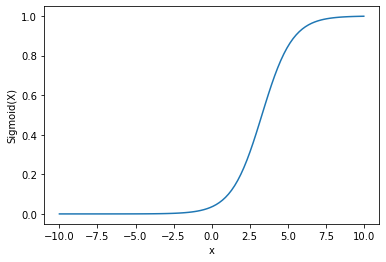

0.0353368440280961


In [6]:
# Если что, вот эта сигмоида
x = np.linspace(-10, 10, 100)
coef = 0.5
sigm = 1/(1 + coef*np.exp(-(x - 4)))
plt.plot(x, sigm) 
plt.xlabel("x") 
plt.ylabel("Sigmoid(X)")
  
plt.show()
print(1/(1 + coef*np.exp(4)))

In [7]:
# Добавляем эти сигмоидные метрики в датафреймы
train_df_m = pd.merge(train_df, url_info_df, how='left',on=['url'])
test_df_m = pd.merge(test_df, url_info_df, how='left',on=['url'])
# Если такого url в test не было в train -- просто обнуляем
test_df_m = test_df_m.fillna(value=0.)
test_df_m.head()


,id,url,title,pos_ratio,neg_ratio,num,pos_sigm,neg_sigm
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...,0.0,1.0,10.0,0.000000,0.998762
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ...",0.0,1.0,6.0,0.000000,0.936621
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12,0.0,0.0,0.0,0.000000,0.000000
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ...",1.0,0.0,1.0,0.090557,0.000000
4,135313,2gis.ru,67,0.0,1.0,75.0,0.000000,1.000000


In [8]:
# Теперь непосредственно обрабатываем тайтлы
# Всё в нижни регистр
train_df_m['title'] = train_df_m['title'].str.lower()
test_df_m['title'] = test_df_m['title'].str.lower()
test_df_m.head()

,id,url,title,pos_ratio,neg_ratio,num,pos_sigm,neg_sigm
0,135309,www.kommersant.ru,шестой кассационный суд в самаре начнет работу...,0.0,1.0,10.0,0.000000,0.998762
1,135310,urexpert.online,"что такое индексация алиментов, кем и в каких ...",0.0,1.0,6.0,0.000000,0.936621
2,135311,imperimeha.ru,женщинам | империя меха - part 12,0.0,0.0,0.0,0.000000,0.000000
3,135312,national-porn.com,"небритые, волосатые киски: порно всех стран и ...",1.0,0.0,1.0,0.090557,0.000000
4,135313,2gis.ru,67,0.0,1.0,75.0,0.000000,1.000000


In [9]:
# Удаляем всё, что не буквы
train_df_m['title'] = train_df_m['title'].str.replace('[^a-zA-Zа-яА-Я ]', '')
test_df_m['title'] = test_df_m['title'].str.replace('[^a-zA-Zа-яА-Я ]', '')
test_df_m.head()

,id,url,title,pos_ratio,neg_ratio,num,pos_sigm,neg_sigm
0,135309,www.kommersant.ru,шестой кассационный суд в самаре начнет работу...,0.0,1.0,10.0,0.000000,0.998762
1,135310,urexpert.online,что такое индексация алиментов кем и в каких с...,0.0,1.0,6.0,0.000000,0.936621
2,135311,imperimeha.ru,женщинам империя меха part,0.0,0.0,0.0,0.000000,0.000000
3,135312,national-porn.com,небритые волосатые киски порно всех стран и на...,1.0,0.0,1.0,0.090557,0.000000
4,135313,2gis.ru,,0.0,1.0,75.0,0.000000,1.000000


In [10]:
import pymorphy2

# Лемматизируем
lemmatizer = pymorphy2.MorphAnalyzer()

lemmatizer_cache = {}
def lem_text(text):
    return ' '.join([lem_token(token) for token in text.split()])

def lem_token(token):
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

train_df_m['title'] = train_df_m['title'].apply(lem_text)
test_df_m['title'] = test_df_m['title'].apply(lem_text)
test_df_m.head()

,id,url,title,pos_ratio,neg_ratio,num,pos_sigm,neg_sigm
0,135309,www.kommersant.ru,шестой кассационный суд в самара начать работа...,0.0,1.0,10.0,0.000000,0.998762
1,135310,urexpert.online,что такой индексация алименты кто и в какой сл...,0.0,1.0,6.0,0.000000,0.936621
2,135311,imperimeha.ru,женщина империя мех part,0.0,0.0,0.0,0.000000,0.000000
3,135312,national-porn.com,небритый волосатый киска порно весь страна и н...,1.0,0.0,1.0,0.090557,0.000000
4,135313,2gis.ru,,0.0,1.0,75.0,0.000000,1.000000


In [67]:
# Убираем стоп-слова
from nltk.corpus import stopwords

# Удаляем стоп-слова
mystopwords = stopwords.words('russian') + stopwords.words('english')

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return u" ".join([token for token in text.split() if not token in mystopwords])
    except:
        return u""

train_df_m['title'] = train_df_m['title'].apply(remove_stopwords)
test_df_m['title'] = test_df_m['title'].apply(remove_stopwords)
#train_df_m.head()
test_df_m.head()

,id,url,title,pos_ratio,neg_ratio,num,pos_sigm,neg_sigm
0,135309,www.kommersant.ru,шестой кассационный суд самара начать работа р...,0.0,1.0,10.0,0.000000,0.998762
1,135310,urexpert.online,индексация алименты случай производиться каков...,0.0,1.0,6.0,0.000000,0.936621
2,135311,imperimeha.ru,женщина империя мех part,0.0,0.0,0.0,0.000000,0.000000
3,135312,national-porn.com,небритый волосатый киска порно весь страна нац...,1.0,0.0,1.0,0.090557,0.000000
4,135313,2gis.ru,,0.0,1.0,75.0,0.000000,1.000000


In [68]:
# Сделаем лучше tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
# Обучаемся и по валидационной выборке
tfidf_vectorizer.fit(pd.concat([train_df_m['title'], test_df_m['title']]))
train_titles_tfidf = tfidf_vectorizer.transform(train_df_m['title'])
test_titles_tfidf = tfidf_vectorizer.transform(test_df_m['title'])
print(train_titles_tfidf.shape)
print(test_titles_tfidf.shape)

(135309, 222911)
(165378, 222911)


In [69]:
# Выравниваем выборку
def balance_data_idxs(data):
    true_idxs = np.arange(data.shape[0]) [data['target'] == True]
    false_idxs = np.arange(data.shape[0]) [data['target'] == False]
    random_false_idxs = np.random.choice(false_idxs, true_idxs.size, replace=False)
    temp = np.concatenate([true_idxs, random_false_idxs])
    random_idxs = np.random.choice(temp, temp.size, replace=False)
    return random_idxs

balance_idxs = balance_data_idxs(train_df_m)
print(balance_idxs)

[ 87323  75542  49689 ... 123057  49055  51933]


In [70]:
# Слепим данные

X_full_balanced = hstack([train_df_m.iloc[balance_idxs,7:], train_titles_tfidf[balance_idxs]]).tocsr()
y_full_balanced = train_df_m['target'][balance_idxs]

X_train, X_test, y_train, y_test = train_test_split(X_full_balanced, y_full_balanced, test_size=0.2, random_state=42)
#X_train = X_train[balance_idxs]
#y_train = y_train.astype(int).values
#y_test = y_test.astype(int).values
print(X_full.shape)
print(y_full.shape)

(135309, 223135)
(135309,)


# Логистическая регрессия

In [97]:
# Вот и чего б не обучить регрессию?
# scores = []
# for i in range(10, 100, 10):
#     #print(i)    
#     log_clf = LogisticRegression(random_state=42, max_iter=i).fit(X_train, y_train)
#     y_pred = log_clf.predict(X_test)
#     y_pred_train = log_clf.predict(X_train)
#     scores.append([i, f1_score(y_test, y_pred)])
#print(scores)


log_clf = LogisticRegression(random_state=42, max_iter=100).fit(X_train, y_train)
y_pred_1 = log_clf.predict(X_test)
y_pred_train_1 = log_clf.predict(X_train)
print('log balanced train', f1_score(y_train, y_pred_train_1))
print('log balanced test ', f1_score(y_test, y_pred_1))

# Скор на всей выборке
X_full = hstack([train_df_m.iloc[:,7:], train_titles_tfidf]).tocsr()
y_full = train_df_m['target']
y_full_pred_1 = log_clf.predict(X_full)
print('log full: ', f1_score(y_full, y_full_pred_1))

log balanced train 0.9916522523877567
log balanced test  0.984984984984985
log full:  0.9777619429351859


In [112]:
# Какие из всей выборки неправильно на регрессии?
# Видно, что чаще оно ложно срабатывает, чем ложно не срабатывает

y_wrong_1 = np.arange(y_full.size)[y_full_pred_1 != y_full]
#y_wrong_1 = balance_idxs[y_wrong_1]

#print(y_wrong_1)

print(train_df_m.iloc[y_wrong_1]['target'].value_counts())
print(np.unique(y_full_pred_1[y_wrong_1], return_counts=True))
train_df_m.iloc[y_wrong_1]

False    500
True     249
Name: target, dtype: int64
(array([False,  True]), array([249, 500]))


,id,url,title,target,pos_ratio,neg_ratio,num,pos_sigm,neg_sigm
330,330,www.artfile.ru,обои видео игра mass effect обои рабочий стол ...,False,0.357143,0.642857,14,0.357135,0.642843
542,542,v-tope24.com,анкета пользователь светлана логинов год лянтор,False,0.306122,0.693878,49,0.306122,0.693878
775,775,mail.ru,екатерина коб голый тыс результат поиск mailru,True,0.016203,0.983797,7900,0.016203,0.983797
926,926,privat-zapisi.biz,,False,0.750000,0.250000,8,0.743194,0.247731
1027,1027,filmpornobesplatno.com,,True,1.000000,0.000000,1,0.090557,0.000000
...,...,...,...,...,...,...,...,...,...
134375,134375,24-info.pro,shane blair белый купальник,False,0.875000,0.125000,8,0.867060,0.123866
134684,134684,converterino.online,download abusada song mp mp free mp,False,0.284211,0.715789,95,0.284211,0.715789
134764,134764,tatcavideo.ru,bigo live kиo nhy sexy dance sn sуi vs mиo xem...,True,0.125000,0.875000,8,0.123866,0.867060
135184,135184,mail.ru,фото группа фото сообщество сумасшедший муж же...,True,0.016203,0.983797,7900,0.016203,0.983797


In [43]:
# Точно ли это они?
X_tt = X_full[y_wrong_1]
y_tt_true = train_df_m['target'][y_wrong_1]
y_tt_pred = log_clf.predict(X_tt)
#print(y_tt_pred)
#print(y_tt_true.to_numpy())
print(y_tt_pred == y_tt_true)
print(np.unique(y_tt_pred == y_tt_true, return_counts=True))

72       False
80        True
144       True
172       True
366       True
         ...  
32150    False
32888     True
33066     True
33112     True
33380     True
Name: target, Length: 318, dtype: bool
(array([False,  True]), array([ 87, 231]))


# Лес

In [96]:
# А теперь лесок
rf_clf = RandomForestClassifier(random_state=42, n_estimators=10, n_jobs = 2).fit(X_train, y_train)
y_pred_2 = rf_clf.predict(X_test)
print('rf balanced test: ', f1_score(y_test, y_pred_2))

# Скор на всей выборке
y_full_pred_2 = rf_clf.predict(X_full)
print('rf-log full: ', f1_score(y_full, y_full_pred_2))

rf balanced test:  0.9925395404356908
rf-log full:  0.9839490145167001


In [94]:
# Какие из всей выборки неправильно на лесе?

y_wrong_2 = np.arange(y_full.size)[y_full_pred_2 != y_full]
#y_wrong_1 = balance_idxs[y_wrong_1]

#print(y_wrong_1)
#train_df_m.iloc[y_wrong_3]

rf-log full:  0.9839490145167001


# Лес с добавленными предсказаниями регрессии

In [95]:
# А теперь лесок с добавленными туда предсказаниями регрессии
train_log_prob = log_clf.predict_proba(X_train)[:,1]
test_log_prob = log_clf.predict_proba(X_test)[:,1]
X_train_log = hstack([X_train, np.transpose([train_log_prob])])
X_test_log = hstack([X_test, np.transpose([test_log_prob])])
rf_log_clf = RandomForestClassifier(random_state=42, n_estimators=14, n_jobs = 2).fit(X_train_log, y_train)
y_pred_3 = rf_log_clf.predict(X_test_log)
print('rf-log balanced test: ', f1_score(y_test, y_pred_3))

# Скор на всей выборке
y_full_pred_1_log = log_clf.predict_proba(X_full)[:,1]
X_full_log = hstack([X_full, np.transpose([y_full_pred_1_log])])
y_full_pred_3 = rf_log_clf.predict(X_full_log)
print('rf-log full: ', f1_score(y_full, y_full_pred_3))

rf-log balanced test:  0.9940351923650461
rf-log full:  0.9882715318090274


In [116]:
# Какие из всей выборки неправильно на лесе с регрессией?
# Видно, что чаще оно ложно срабатывает, чем ложно не срабатывает

y_wrong_3 = np.arange(y_full.size)[y_full_pred_3 != y_full]
#y_wrong_1 = balance_idxs[y_wrong_1]

print('Должно быть')
print(train_df_m.iloc[y_wrong_3]['target'].value_counts())
print('Есть')
print(np.unique(y_full_pred_3[y_wrong_3], return_counts=True))
train_df.iloc[y_wrong_3]

Должно быть
False    365
True      31
Name: target, dtype: int64
Есть
(array([False,  True]), array([ 31, 365]))


,id,url,title,target
330,330,www.artfile.ru,"Обои Видео Игры Mass Effect 3, обои для рабоче...",False
926,926,privat-zapisi.biz,30,False
1042,1042,iehb.info,Download free Kelly capone gets the vibrator i...,False
1450,1450,ru.darknun.com,Страстный секс в постели с азиаткой Асой Акирой,False
1797,1797,suj.nu,Скачать бесплатно Залезли в комнату главной се...,False
...,...,...,...,...
133957,133957,viyoutube.co,HOW TO TRAIN A PUPPY TO BITE ANYTHING WITH MAS...,False
134279,134279,xyya.net,7 самых-самых сортов арбузов (7 фото+текст) » ...,False
134375,134375,24-info.pro,Shane Blair в белом купальнике,False
135200,135200,1tv1.ru,Поиск по сайту » DataLife Engine,False


# Итого

In [117]:
# А теперь слепим Ту-Самую-Классификацию
X_validate = hstack([test_df_m.iloc[:,6:], test_titles_tfidf])

#y_validate = log_clf.predict(X_validate)

validate_log_prob = log_clf.predict_proba(X_validate)[:,1]
X_validate_log = hstack([X_validate, np.transpose([validate_log_prob])])
y_validate = rf_log_clf.predict(X_validate_log)

validate_df = pd.DataFrame({'id' : test_df_m['id'], 'target' : y_validate})
print(validate_df)
validate_df.to_csv('final.csv', index=False)

            id  target
0       135309   False
1       135310   False
2       135311   False
3       135312    True
4       135313   False
...        ...     ...
165373  300682   False
165374  300683   False
165375  300684   False
165376  300685   False
165377  300686   False

[165378 rows x 2 columns]
